# PyGIMLi - DCIP (real dataset)

Using the DCIP (Direct Current, Induced Polarization) solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve problem with a real dataset.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_dcip/pygimli_dcip_century_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Note: This notebook is adapted from a SimPEG example authored by Lindsey Heagy and presented at Transform 2020. [Original Materials](https://curvenote.com/@simpeg/transform-2020-simpeg-tutorial/!6DDumb03Le6D8N8xuJNs)

# Frequency domain vs Time domain measurements of chargeability

https://gpg.geosci.xyz/content/induced_polarization/induced_polarization_data.html

Martin, T., Günther, T., Orozco, A. F., & Dahlin, T. (2020). Evaluation of spectral induced polarization field measurements in time and frequency domain. Journal of Applied Geophysics, 180. https://doi.org/10.1016/j.jappgeo.2020.104141

Mutton, A. J. (2000). The application of geophysics during evaluation of the Century zinc deposit. Geophysics, 65(6), 1946–1960. https://doi.org/10.1190/1.1444878

## 0. Set up environment

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

We will need the following packages:

- `os` to list and load dataset
- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pygimli
import cofi

## 1. Load the data

We will need to download the preprocessed dataset first. This notebook [century_data_preprocessing.ipynb](century_data_preprocessing.ipynb) contains the code for data preprocessing.

In [6]:
dc_data = np.loadtxt("century_dc_data.txt")


In [7]:
def load_leapfrog_geologic_section(filename="./century/geologic_section.csv"):
    """
    Load the geologic cross section. 
    """
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data
geologic_section = load_leapfrog_geologic_section()

In [50]:
a_locs = dc_data[:,0]
b_locs = dc_data[:,1]
m_locs = dc_data[:,2]
n_locs = dc_data[:,3]
dc_obs = dc_data[:,4]
ip_obs = dc_data[:,5]*0.7 # https://gpg.geosci.xyz/content/induced_polarization/induced_polarization_data.html
geo_factors = dc_data[:,6]


# pygimli uses radians internally

In [45]:
location_start = np.min(a_locs)
location_stop = np.max(n_locs)
location_interval = m_locs[1] - m_locs[0]
location_num = int((location_stop - location_start) / location_interval + 1)

location_start, location_stop, location_interval, location_num

(26000.0, 29200.0, 100.0, 33)

## 2. Create a PyGIMLi measuring scheme and fill in the data

In [46]:
data = pygimli.DataContainerERT()

for sensor in np.linspace(location_start, location_stop, location_num):
    data.createSensor((sensor, 0.0, 0.0))

locs_sources = np.vstack((a_locs, b_locs)).T
locs_receivers = np.vstack((m_locs, n_locs)).T
for i in range(len(locs_sources)):
    src = locs_sources[i]
    src_idx = (src - location_start) / location_interval
    rec = locs_receivers[i]
    rec_idx = (rec - location_start) / location_interval
    data.createFourPointData(i, src_idx[0], src_idx[1], rec_idx[0], rec_idx[1])
data

Data: Sensors: 33 data: 151, nonzero entries: ['a', 'b', 'm', 'n', 'valid']

In [66]:
np.min(dc_obs)

38.999738552941224

In [79]:
data["rhoa"] = dc_obs
data["phia"] = -ip_obs/1000. # to make me happy
data["k"] = pygimli.physics.ert.createGeometricFactors(data, numerical=True)

data_complex_vals = data["rhoa"].array() * np.exp(1j * data["phia"].array())

11/11/22 - 11:19:53 - pyGIMLi - INFO - Cache /home/jrh/csiro/research/cofi/external/gimli/gimli/pygimli/physics/ert/ert.py:createGeometricFactors restored (2.0s x 1): /home/jrh/.cache/pygimli/8400096981792772276


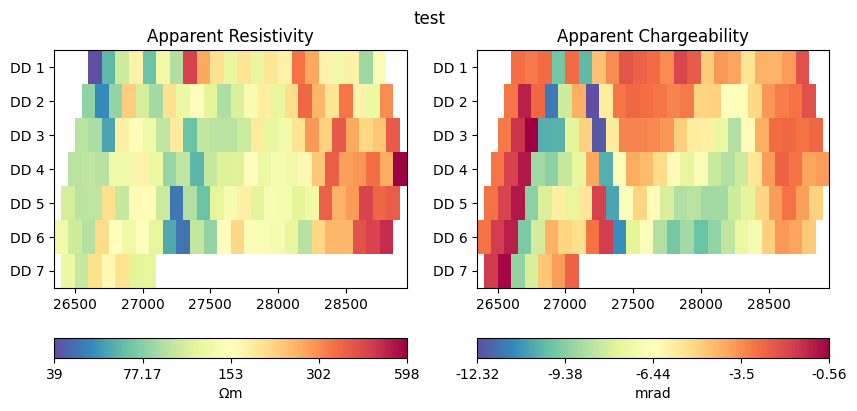

In [80]:
# def plot_data(data, data_vals, title):
#     fig, ax = plt.subplots(1, 1)
#     pygimli.physics.ert.showERTData(
#         data, 
#         vals=data_vals, 
#         label=r"$\Omega$m", 
#         ax=ax, 
#     )
def plot_data(pg_data, data, title):
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    pygimli.physics.ert.showERTData(pg_data, vals=np.real(data), label=r"$\Omega$m", ax=axes[0])
    axes[0].set_title("Apparent Resistivity")
    pygimli.physics.ert.showERTData(pg_data, vals=np.arctan2(np.imag(data), np.real(data))*1000, label=r"mrad", ax=axes[1])
    #pygimli.physics.ert.showERTData(pg_data, vals=ip_obs, label=r"mrad", ax=axes[1])

    axes[1].set_title("Apparent Chargeability")
    fig.suptitle(title)

plot_data(data, data_complex_vals, "test")

## 3. Create inversion mesh

In [81]:
# calculate dimension in x and z directions
n_cells_per_spacing = 4
dx = location_interval / n_cells_per_spacing
dz = dx

# calculate x range
x_range = (location_start, location_stop)

# calculate z range
ab_midpoints = (a_locs + b_locs) / 2
mn_midpoints = (m_locs + n_locs) / 2
ab_mn_separation = np.abs(ab_midpoints - mn_midpoints)
max_separation = np.max(ab_mn_separation)
z_depth = - max_separation / 3.
z_range = (z_depth, 0.)

# print
print(f"Mesh dimension: ({dx}, {dz})")
print(f"Mesh range x: {x_range}")
print(f"Mesh range z: {z_range}")

Mesh dimension: (25.0, 25.0)
Mesh range x: (26000.0, 29200.0)
Mesh range z: (-266.6666666666667, 0.0)


In [82]:
# params for creating mesh nodes
n_midd_extra = 4
n_midd_x = np.ceil(np.diff(x_range)/dx) + n_midd_extra*2
n_top_z = np.ceil(np.diff(z_range)/dz) + n_midd_extra
n_side = 10         # number of nodes extending in x and z
extending_factor = 1.3
extending_list = (np.ones(n_side) * extending_factor) ** (np.arange(n_side) + 1)

# create nodes in x direction
dist_x_left = (extending_list * dx)[::-1]
dist_x_midd = int(n_midd_x) * [dx]
dist_x_right = extending_list * dx
dist_x = np.hstack((dist_x_left, dist_x_midd, dist_x_right))
nodes_x = np.r_[(x_range[1]+x_range[0])/2-np.sum(dist_x)/2, dist_x].cumsum()

# create nodes in z direction
dist_z_bot = (extending_list * dz)[::-1]
dist_z_top = int(n_top_z) * [dz]
dist_z = np.hstack((dist_z_bot, dist_z_top))
nodes_z = np.r_[-np.sum(dist_z), dist_z].cumsum()

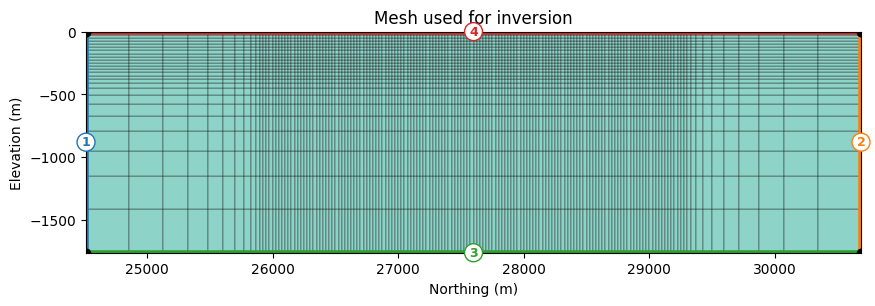

In [83]:
inv_mesh = pygimli.meshtools.createGrid(x=nodes_x, y=nodes_z)

_, ax = plt.subplots(figsize=(10,8))
pygimli.show(inv_mesh, showMesh=True, markers=True, colorBar=False, ax=ax)
ax.set_title("Mesh used for inversion");
ax.set_xlabel("Northing (m)");
ax.set_ylabel("Elevation (m)");

## 4. Set up forward operator and regularization matrix

In [93]:
ert_mgr = pygimli.physics.ert.ERTManager(data)
ert_mgr.setMesh(inv_mesh)

forward_oprt = ert_mgr.fop
forward_oprt.setComplex(True)
forward_oprt.setData(data)
forward_oprt.setMesh(inv_mesh, ignoreRegionManager=True)

region_manager = forward_oprt.regionManager()
region_manager.setConstraintType(2)
Wm = pygimli.matrix.SparseMapMatrix()
region_manager.fillConstraints(Wm)
Wm = pygimli.utils.sparseMatrix2coo(Wm)

11/11/22 - 11:23:41 - pyGIMLi - INFO - Found 1 regions.


In [85]:
def starting_model(ert_manager, inv_mesh, val=None):
    data = ert_manager.data
    start_model = np.ones(ert_manager.paraDomain.cellCount()) * pygimli.utils.complex.toComplex(np.median(data['rhoa']),np.median(data['phia']))
    start_model_log = np.log(start_model)
    start_model_log_real = np.concatenate((np.real(start_model_log), np.imag(start_model_log)))
    return start_model, start_model_log, start_model_log_real


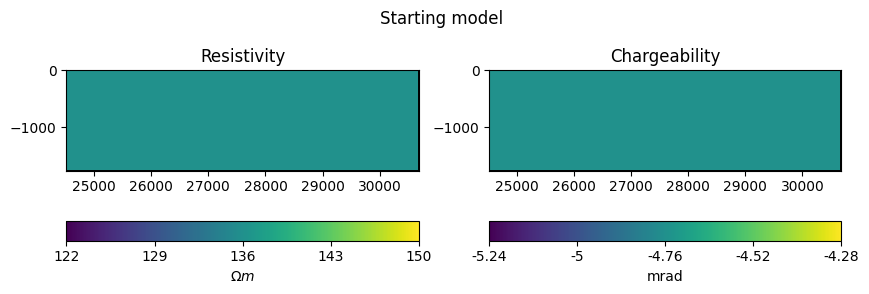

In [90]:
#start_model = np.ones(inv_mesh.cellCount()) * np.median(data["rhoa"])
#start_model_log = np.log(start_model)

def plot_model(mesh, model_vec, title):
    fig, axes = plt.subplots(1,2,figsize=(10,3))
    pygimli.show(mesh, data=np.abs(model_vec), label=r"$\Omega m$", ax=axes[0])
    #axes[0].set_xlim(x_inv_start, x_inv_stop)
    #axes[0].set_ylim(y_inv_start, y_inv_stop)
    axes[0].set_title("Resistivity")
    pygimli.show(mesh, data=np.arctan2(np.imag(model_vec), np.real(model_vec)) * 1000, label=r"mrad", ax=axes[1])
    #axes[1].set_xlim(x_inv_start, x_inv_stop)
    #axes[1].set_ylim(y_inv_start, y_inv_stop)
    axes[1].set_title("Chargeability")
    fig.suptitle(title)
    
start_model, start_model_log, start_model_log_real = starting_model(ert_mgr, inv_mesh, val=None)
plot_model(ert_mgr.paraDomain, start_model, "Starting model")

## 5. Create utility functions to pass to CoFI

In [91]:
# Utility Functions (additional)

def _ensure_numpy(model):
    if "torch.Tensor" in str(type(model)):
        model = model.cpu().detach().numpy()
    return model

# accepts model in log complex space -> produces y in log complex space
def get_response(model_log, fop):
    model = np.exp(model_log)
    model = _ensure_numpy(model)
    model_re_im = pygimli.utils.squeezeComplex(model)
    synth = np.array(fop.response(model_re_im))
    return np.log(pygimli.utils.toComplex(synth))

# accepts model in log complex space -> produces Jac in log-log complex space
def get_jacobian(model_log, fop):
    model = np.exp(model_log)
    model = _ensure_numpy(model)
    model_re_im = pygimli.utils.squeezeComplex(model)
    J_block = fop.createJacobian(model_re_im)
    J_re = np.array(J_block.mat(0))
    J_im = np.array(J_block.mat(1))
    J = J_re + 1j * J_im
    y_synth_log = get_response(model_log, fop)
    J_loglog = J / np.exp(y_synth_log[:,np.newaxis]) * model[np.newaxis,:]
    return J_loglog

# accepts model/data in log complex space -> produces residuals in log complex space
def get_residuals(model_log, data_log, fop):
    y_synth_log = get_response(model_log, fop)
    return data_log - y_synth_log

# accepts model/data in log complex space -> produces data misfit in log complex space
def get_data_misfit(model_log, data_log, fop):
    res = get_residuals(model_log, data_log, fop)
    return res.T.dot(res)

# accepts model in log complex space -> produces regularizaton value in log complex space
def get_regularization(model_log, lamda, Wm):
    weighted_model_log = Wm.dot(model_log)
    return lamda * weigted_model_log.T.dot(weighted_model_log)

# accepts model in log real space -> produces objective value in log real space
def get_objective(model_log_real, data_log, fop, lamda, Wm):
    # convert model_log_real into complex numbers
    nparams = int(len(model_log_real) // 2)
    model_log = model_log_real[:nparams] + 1j * model_log_real[nparams:]
    # calculate data misfit
    res = get_residuals(model_log, data_log, fop)
    data_misfit = res.T.dot(res)
    # calculate regularization term
    weighted_model_log = Wm.dot(model_log)
    reg = lamda * weighted_model_log.T.dot(weighted_model_log)
    # sum up
    result = np.abs(data_misfit + reg)
    return result

# accepts model in log real space -> produces gradient vector in log real space
def get_gradient(model_log_real, data_log, fop, lamda, Wm):
    # convert model_log_real into complex numbers
    nparams = int(len(model_log_real) // 2)
    model_log = model_log_real[:nparams] + 1j * model_log_real[nparams:]
    # calculate gradient for data misfit
    res = get_residuals(model_log, data_log, fop)
    jac = get_jacobian(model_log, fop)
    data_misfit_grad = - jac.conj().T.dot(res)
    # calculate gradient for regularization term
    reg_grad = lamda * Wm.T.dot(Wm).dot(model_log)
    # sum up
    grad_complex = data_misfit_grad + reg_grad
    grad_real = np.concatenate((np.real(grad_complex), np.imag(grad_complex)))
    return grad_real

# accepts model in log real space -> produces hessian matrix in log real space
def get_hessian(model_log_real, data_log, fop, lamda, Wm):
    # convert model_log_real into complex numbers
    nparams = int(len(model_log_real) // 2)
    model_log = model_log_real[:nparams] + 1j * model_log_real[nparams:]
    # calculate hessian for data misfit
    res = get_residuals(model_log, data_log, fop)
    jac = get_jacobian(model_log, fop)
    data_misfit_hessian = - jac.conj().T.dot(jac)
    # calculate hessian for regularization term
    reg_hessian = lamda * Wm.T.dot(Wm)
    # sum up
    hessian_complex = data_misfit_hessian + reg_hessian
    hessian_real = np.zeros((2*nparams, 2*nparams))
    hessian_real[:nparams,:nparams] = np.real(hessian_complex)
    hessian_real[:nparams,nparams:] = -np.imag(hessian_complex)
    hessian_real[nparams:,:nparams] = np.imag(hessian_complex)
    hessian_real[nparams:,nparams:] = np.real(hessian_complex)
    return hessian_real

# accepts model in log real space -> produces model in normal complex space
def post_process(model_log_real):
    nparams = int(model_log_real.shape[0]/2)
    return np.exp(model_log_real[:nparams] + 1j * model_log_real[nparams:])

In [95]:
# test
get_response(start_model_log_real, forward_oprt)

array([4.89578   +0.00732294j, 4.88914808+0.00732294j,
       4.90147184+0.00732294j, 4.89647011+0.00732294j,
       4.89013964+0.00732294j, 4.90533059+0.00732294j,
       4.90184843+0.00732294j, 4.89708465+0.00732294j,
       4.89090722+0.00732294j, 4.90740218+0.00732294j,
       4.90544444+0.00732294j, 4.90218731+0.00732294j,
       4.89750627+0.00732294j, 4.89158902+0.00732294j,
       4.90735594+0.00732294j, 4.9073663 +0.00732294j,
       4.90565671+0.00732294j, 4.90240972+0.00732294j,
       4.89796177+0.00732294j, 4.89210603+0.00732294j,
       4.90185605+0.00732294j, 4.9070536 +0.00732294j,
       4.90751076+0.00732294j, 4.90574251+0.00732294j,
       4.90273009+0.00732294j, 4.89825776+0.00732294j,
       4.89254665+0.00732294j, 4.89954229+0.00732294j,
       4.90713424+0.00732294j, 4.90749184+0.00732294j,
       4.9060128 +0.00732294j, 4.90286923+0.00732294j,
       4.89852149+0.00732294j, 4.89293082+0.00732294j,
       4.90285561+0.00732294j, 4.907465  +0.00732294j,
       4.9

## 6. Run inversion with CoFI

In [98]:
# hyperparameters
lamda=0.001

# CoFI - define BaseProblem
dcip_problem = cofi.BaseProblem()
dcip_problem.name = "DC-IP defined through PyGIMLi"
dcip_problem.set_objective(get_objective, args=[log_data, forward_oprt, 0.001, Wm])
dcip_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, 0.001, Wm])
dcip_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, 0.001, Wm])
dcip_problem.set_initial_model(start_model_log_real)

In [101]:
# test
dcip_problem.objective(start_model_log_real)

42.86136545826268

In [ ]:
# CoFI - define InversionOptions
inv_options = cofi.InversionOptions()
inv_options.set_tool("cofi.simple_newton")
inv_options.set_params(max_iterations=2, step_length=0.0001)

# CoFI - define Inversion and run
inv = cofi.Inversion(dcip_problem, inv_options)
inv_result = inv.run()

print(f"\nNumber of objective function evaluations: {inv_result.n_obj_evaluations}")
print(f"Number of gradient function evaluations: {inv_result.n_grad_evaluations}")
print(f"Number of hessian function evaluations: {inv_result.n_hess_evaluations}")

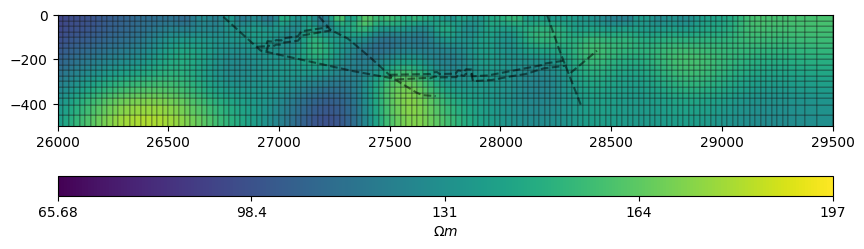

In [28]:
_, ax = plt.subplots(figsize=(10,8))
pygimli.show(ert_mgr.paraDomain, data=np.exp(inv_result.model), label="$\Omega m$", showMesh=True, ax=ax)
ax.set_xlim([26000,29500])
ax.set_ylim([-500,0])

for data in geologic_section:
    ax.plot(data[:,0], data[:,1], 'k--', alpha=0.5)